# Global OOR detection

In this tutorial, we show how EpiPack detect global OOR cell type within the classification space. We still use the mapped embeddings from ``ref.obsm['z_ref']`` and ``query.obsm['z_ref']`` as an example. We will remove **B cell** from the reference data and re-train the classifier.

In [1]:
## load epipack package

# !pip install --upgrade epipackpy
import scanpy as sc
import numpy as np
import pandas as pd

import epipackpy as epk
print(epk.__version__)

1.0.1dev4


In [2]:
## load ref and query
ref = sc.read_h5ad("tutorial_reference.h5ad")
query = sc.read_h5ad("tutorial_query.h5ad")

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Here we remove B cell to create pseudo-disease data. Since this is just a showcase, users don't need to run this step when using EpiPack

In [3]:
ref = ref[ref.obs['cell_type_new']!= "B cell"]

### Label encoding

Before running the model, we suggest use ``sklearn LabelEncoder`` module to encode the ground truth label set in the reference. 

In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(ref.obs.cell_type_new)

### Classifier training

In [5]:
clf = epk.ml.Classifier(ref_latent_emb=ref.obsm['z_ref'], ref_label=y, hidden_num=64, batchnorm=False)
clf.train_model(nepochs=100)

- Classifier initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Classifier intialization completed.


Epochs: 100%|██████████| 100/100 [01:33<00:00,  1.07it/s, loss_inner_val=0.0131, loss_inter_val=0.058] 


You can get the predicted from the trained classifier. Meanwhile, if you would like to detect novel cell types, please follow the code block below.

In [6]:
## normal cell type annotation step

result, _ = clf.get_z(query.obsm['z_query'])
querylabel = le.inverse_transform(result)

## [OOR detection] Before running global oor detector, please obtain joint classification space

ref.obs["experiment_set"] = "atlas"
query.obs["experiment_set"] = "query"
tmp = sc.concat([ref, query])
tmp.obsm['z_joint_origin'] = np.concatenate([ref.obsm['z_ref'], query.obsm['z_query']])

_, classification_space = clf.get_z(tmp.obsm['z_joint_origin'])

/tmp/ipykernel_2966373/908134518.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ref.obs["experiment_set"] = "atlas"
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Now we have the joint classification space (referecne + query)

In [11]:
tmp.obsm['z_joint_classification'] = classification_space.detach().cpu().numpy()

In [12]:
tmp[tmp.obs["experiment_set"] == "atlas"]

View of AnnData object with n_obs × n_vars = 19735 × 3000
    obs: 'celltype', 'batch_id', 'leiden', 'cell_type_new', 'batch_code', 'experiment_set'
    obsm: 'X_pca', 'X_umap', 'epipack', 'z_joint_origin', 'z_joint_classification'
    layers: 'count'

In [13]:
ref_ = tmp[tmp.obs["experiment_set"] == "atlas"].copy()
query_ = tmp[tmp.obs["experiment_set"] == "query"].copy()
goor = epk.ml.Global_oor_detector(ref_.obsm['z_joint_classification'], 
                                  query_.obsm['z_joint_classification'], 
                                  y, 
                                  result)

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


- Initializing global OOR detector...
- Detector is ready


/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Run detection

In [ ]:
reject_cell_list, prob_score = goor.annotate(confidence_threshold=0.01) #you can set your own threshold, we recommand 0.01.

- Mahalanobis distance calculating...
- Start quantifying global OOR cells...
- Annotation complete


Now we set those cells with significant value<0.01 as "Unknown" cell type. Since "B cell" is not in the reference set, those query B cells are regarded as OOR type and should be annotated as "Unknown",

In [15]:
querylabel = le.inverse_transform(result)
querylabel[reject_cell_list] = 'Unknown'
query.obs['predicted_label'] = querylabel

We visualize the predicted label below. You can find that those B cells are labeled as "Unknown" in the predicted label set.

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: The 'old_style' error capturing is deprecated and will be replaced by `new_style` in a future release.
  init_rp_tree(data, dist, current_graph, leaf_array)
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/pynndescent/pynndescent_.py:348: NumbaPendingDeprecationWarning: The 'old_style' error capturing is deprecated and will be replaced by `new_style` in a future release.
  init_random(n_neighbors, data, current_graph, dist, rng_state)
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/pynndescent/pynndescent_.py:358: NumbaPendingDeprecation

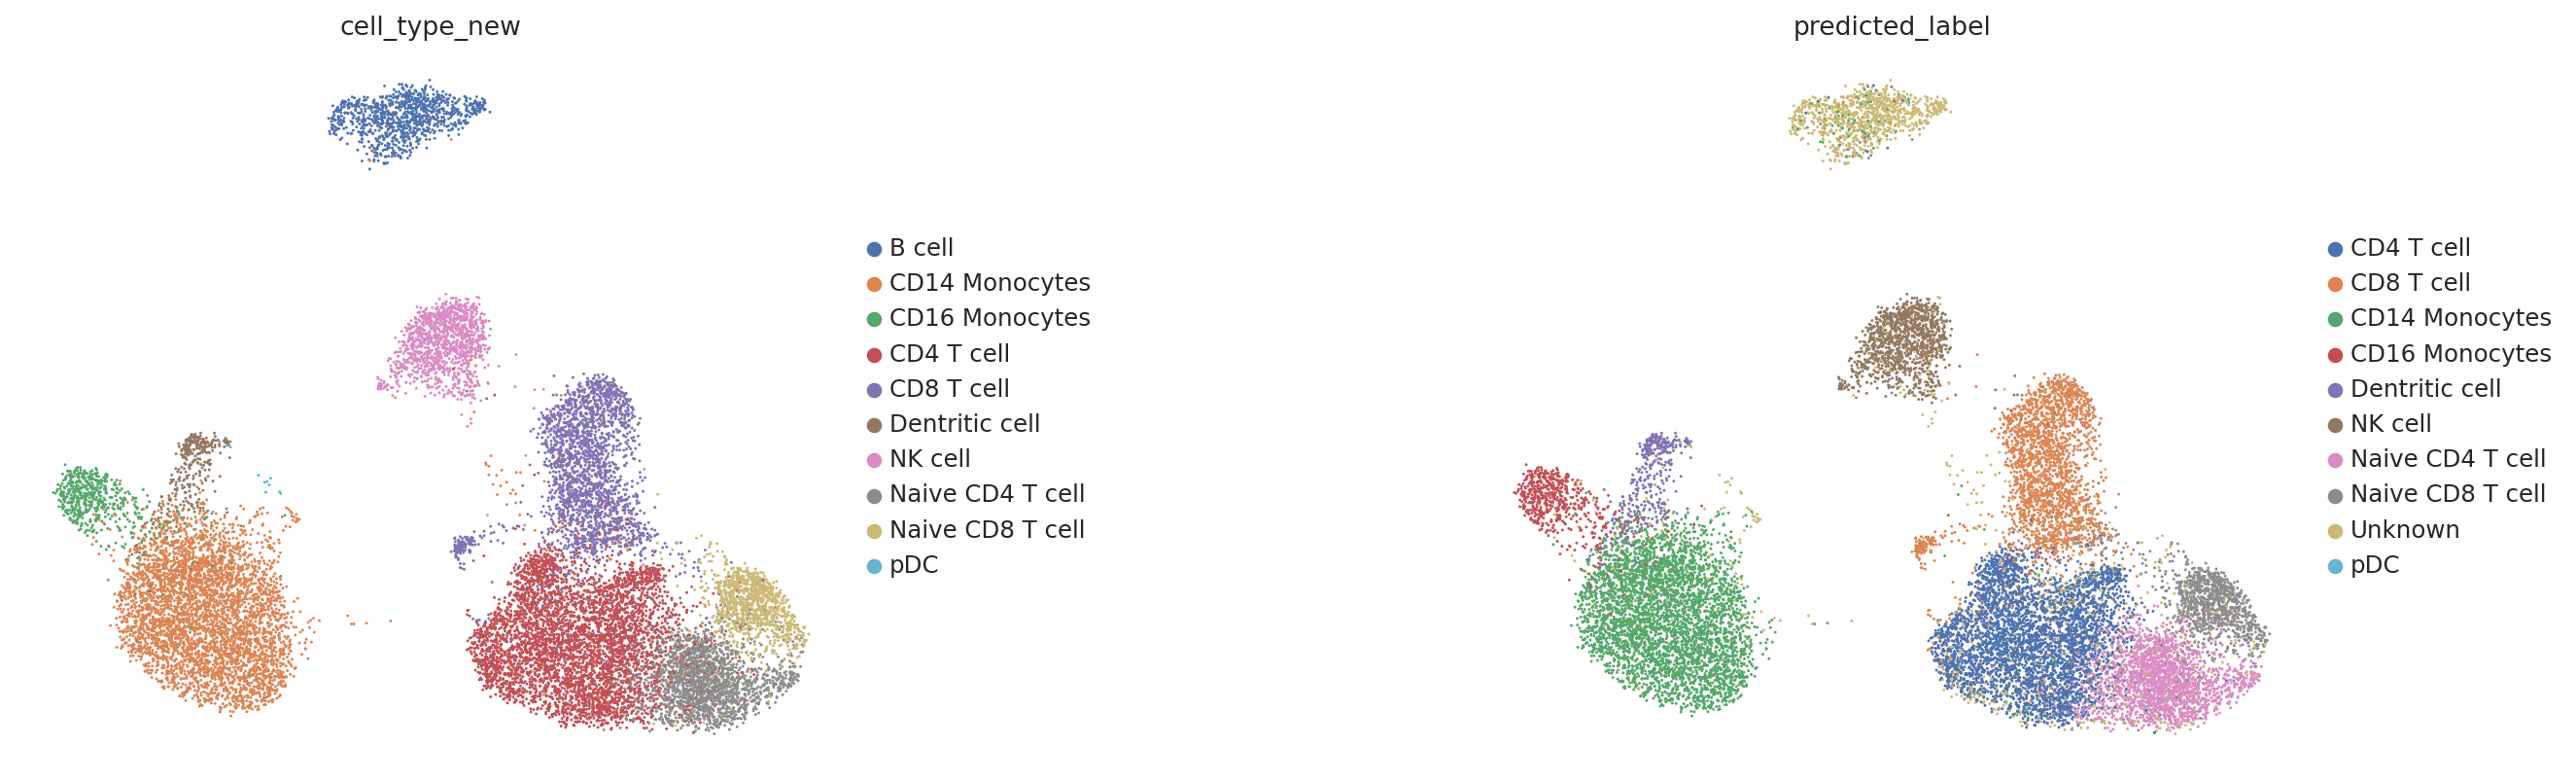

In [16]:
import seaborn as sns

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()

sc.pp.neighbors(query, n_neighbors=50, use_rep='z_query')
sc.tl.umap(query)
#sc.tl.leiden(tmp, resolution=1.5)
sc.pl.umap(query, color=['cell_type_new', 'predicted_label'], ncols=2, wspace=0.6)

Uncertainty score visualization also reflect the result.

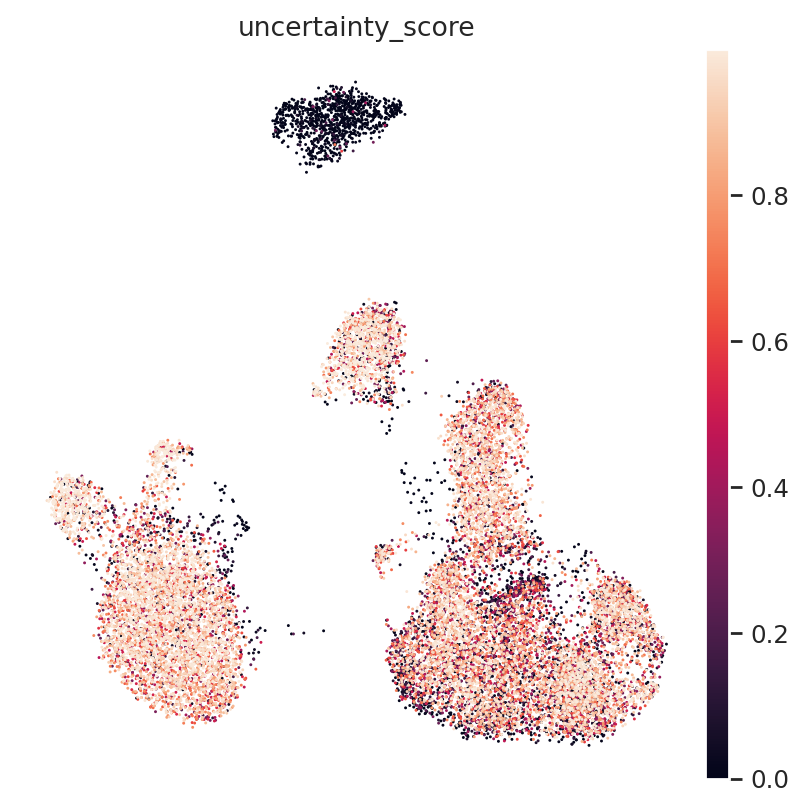

In [17]:
query.obs['uncertainty_score'] = np.array(prob_score)
sc.pl.umap(query, color=['uncertainty_score'], ncols=2, wspace=0.6)

**You can also apply OOR detector directly on the reference mapping space**. You will find that the detector keeps working well. 

In [ ]:
goor = epk.ml.Global_oor_detector(ref.obsm['z_ref'], 
                                  query.obsm['z_query'], 
                                  y, 
                                  result)

reject_cell_list, prob_score = goor.annotate(confidence_threshold=0.01) #you can set your own threshold, we recommand 0.01.
querylabel = le.inverse_transform(result)
querylabel[reject_cell_list] = 'Unknown'
query.obs['predicted_label'] = querylabel

- Initializing global OOR detector...
- Detector is ready
- Mahalanobis distance calculating...
- Start quantifying global OOR cells...
- Annotation complete


/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


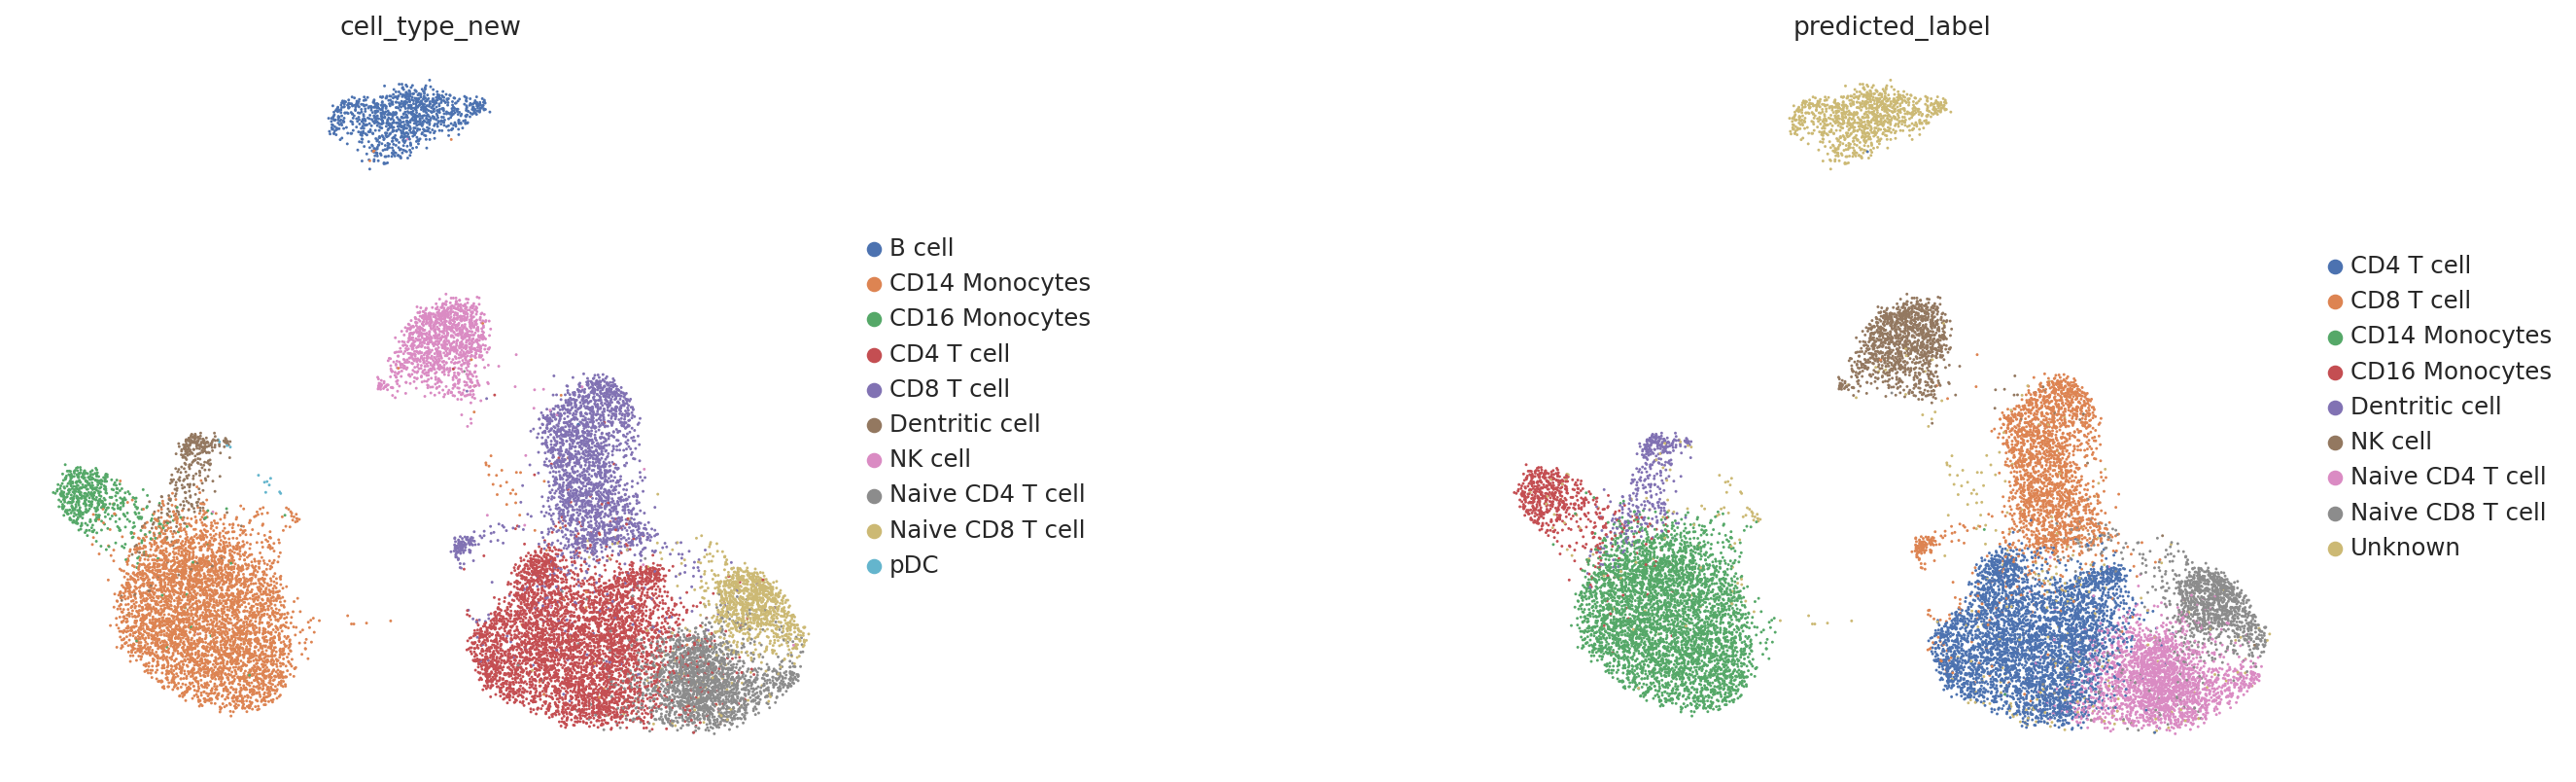

In [22]:
sc.tl.umap(query)
#sc.tl.leiden(tmp, resolution=1.5)
sc.pl.umap(query, color=['cell_type_new', 'predicted_label'], ncols=2, wspace=0.6)

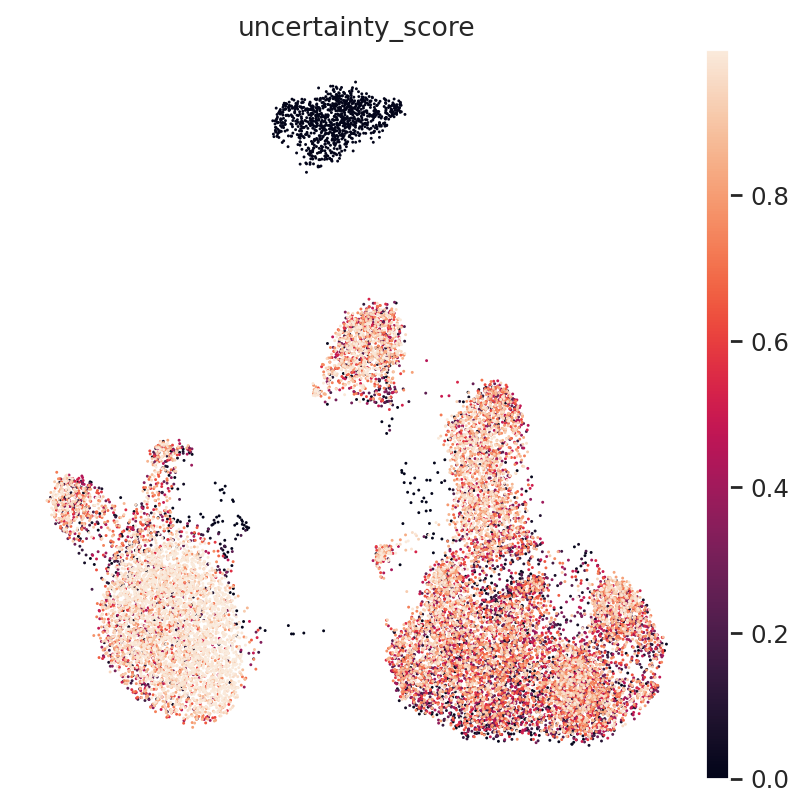

In [23]:
query.obs['uncertainty_score'] = np.array(prob_score)
sc.pl.umap(query, color=['uncertainty_score'], ncols=2, wspace=0.6)

Quantitative result shows that our detector has a high sensitive on that global OOR cell type

In [25]:
id = np.zeros(len(query))
id[np.where(query.obs['cell_type_new']=='B cell')] = 1

id_test = []
for i in list(query.obs['predicted_label']):
    if i == 'Unknown':
        id_test.append(1)
    else:
        id_test.append(0)

id_test = np.array(id_test)
id = id.astype(bool)
id_test = id_test.astype(bool)

pd_result = {"TP": id & (id_test), "FN": id & (~id_test), "FP": (~id) & (id_test), "TN": (~id) & (~id_test)}
pd_result = pd.DataFrame(pd_result)
tpr_df = pd.DataFrame(pd_result[["TP", "FP", "FN", "TN"]].sum()).T

tpr_df["TPR"] = tpr_df["TP"] / (tpr_df["TP"] + tpr_df["FN"])
tpr_df["FPR"] = tpr_df["FP"] / (tpr_df["FP"] + tpr_df["TN"])
tpr_df["FDR"] = tpr_df["FP"] / (tpr_df["FP"] + tpr_df["TP"])

In [26]:
tpr_df

,TP,FP,FN,TN,TPR,FPR,FDR
0,989,351,1,16004,0.99899,0.021461,0.26194
